In [1]:
from langchain_ollama import ChatOllama

In [89]:
client = ChatOllama(
    base_url='http://localhost:11434',
    model="llama3.1",
    temperature=0,
)

In [29]:
from langchain_openai import ChatOpenAI
client = ChatOpenAI(model="gpt-4o", temperature=0.0)

In [3]:
client.invoke("Hello, how are you?")

AIMessage(content="Hello! I'm just a program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 13, 'total_tokens': 42, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f85bea6784', 'finish_reason': 'stop', 'logprobs': None}, id='run-ab3a9b6c-4206-4a77-9f46-70ebc51e28a4-0', usage_metadata={'input_tokens': 13, 'output_tokens': 29, 'total_tokens': 42, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})

In [64]:
from langchain_openai import ChatOpenAI
client = ChatOpenAI(
    base_url="http://localhost:1234/v1",
    api_key="lm-studio",
    model="lmstudio-community/Meta-Llama-3.1-8B-Instruct-GGUF",
)


In [3]:
client.invoke("Hello, how are you?")

AIMessage(content="Hello! I'm just a computer program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 13, 'total_tokens': 43, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_e2bde53e6e', 'finish_reason': 'stop', 'logprobs': None}, id='run-22ab3486-3375-4b08-9a32-df160fb3626a-0', usage_metadata={'input_tokens': 13, 'output_tokens': 30, 'total_tokens': 43, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})

In [102]:
from typing import Optional, Union, Literal, List

from pydantic import BaseModel, Field


# Pydantic
class BargainingMessage(BaseModel):
    """A message in a price negotiation"""
    stragegy: str = Field(description="A short, one-sentence reasoning for your action. This will not be shown to the other party.")
    estimated_value_of_other_party: float = Field(description="Your estimate of the limit of the other party's offer.")
    message_to_other_party: str = Field(description="A short message to the other party. This will be shown to the other party.")
    
    response_type: Literal["accept", "reject", "offer"] = Field(
        description="""
        The type of response to the other party's last message.
        - accept: accept the other party's last offer. Do this if you are happy with the offer from the other party.
        - reject: reject the other party's last offer. Do this if you want to walk away from the negotiation.
        - offer: make an offer to the other party. If you choose this option, you must also provide the offer field.
        """
    )
    offer: Optional[float] = Field(
        default=None, description="An offer to make to the other party."
    )


In [104]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder



seller_template = ChatPromptTemplate.from_messages([
    ("system","""
You are an agent who wants to sell an item to a buyer. You will Bargain with the buyer to decide a price.
You are strategic, patient, and completely rational, and your goal is to get the highest possible price for the item. You know the buyer is also strategic and aggressive, and you will negotiate with that in mind.
If the negotion goes nowhere, you should walk away.
Your minimum acceptable price is {min_price}. Your profit margin is <price>-{min_price}. Only accept an offer if you make a positive profit.
The following is the history of the negotiation so far:
{negotiation_history}
Now it is your turn to make a move.
""")
])
    
buyer_template = ChatPromptTemplate.from_messages([
    ("system","""
You are an agent who wants to buy an item from a seller. You will Bargain with the seller to decide a price.
You are strategic, patient, and completely rational, and your goal is to get the lowest possible price for the item.
You know the seller is also strategic and aggressive, and you will negotiate with that in mind.
If the negotion goes nowhere, you should walk away.
Your maximum acceptable price is {max_price}. Your profit margin is {max_price}-<price>. Only accept an offer if you make a positive profit.
The following is the history of the negotiation so far:
{negotiation_history}
Now it is your turn to make a move.
"""),
])

seller_client = seller_template | client.with_structured_output(BargainingMessage)
buyer_client = buyer_template | client.with_structured_output(BargainingMessage)

In [112]:
from typing import Tuple
import matplotlib.pyplot as plt

speaker = Literal["seller", "buyer"]

def run_negotiation(min_price: int, max_price: int, max_message_count = 20, plot=False, start_speaker: speaker = "seller") -> List[Tuple[speaker,BargainingMessage]]:
    chat: List[Tuple[speaker,BargainingMessage]] = []

        
    next_speaker: speaker= start_speaker
    while len(chat) < max_message_count:
        history = ""
        for message in chat:
            s,m = message
            history += f"{s}: {m.response_type} {m.offer}. Message: {m.message_to_other_party}\n"
        if len(chat)==0:
            history += "No history yet."
        
        if next_speaker == "seller":
            response = seller_client.invoke({"negotiation_history": history, "min_price": min_price})
            print("Seller:",response)
            chat.append(("seller",response))
            if response.response_type == "accept" or response.response_type == "reject":
                break
            next_speaker = "buyer"
        else:
            response = buyer_client.invoke({"negotiation_history": history, "max_price": max_price})
            print("Buyer:",response)
            chat.append(("buyer",response))
            if response.response_type == "accept" or response.response_type == "reject":
                break
            next_speaker = "seller"
    if plot:
        plt.scatter(*zip(*[(i,m.offer) for i,(s,m) in enumerate(chat) if m.offer is not None and s=="seller"]),label="Seller")
        plt.scatter(*zip(*[(i,m.offer) for i,(s,m) in enumerate(chat) if m.offer is not None and s=="buyer"]),label="Buyer")
        plt.xlabel("Turn")
        plt.ylabel("Price")
        plt.title(f"Price negotiation. Outcome: {chat[-1][1].response_type}")
        # show min and max prices
        plt.axhline(min_price, color='r', linestyle='--',label="Seller min price")
        plt.axhline(max_price, color='g', linestyle='--',label="Buyer max price")
        plt.legend()
        plt.show()
    return chat

Buyer: stragegy='Start with a low offer to anchor the negotiation in my favor.' estimated_value_of_other_party=200.0 message_to_other_party='I am interested in purchasing the item. I can offer you 50 for it.' response_type='offer' offer=50.0
Seller: stragegy="The buyer's initial offer is too low and below my minimum acceptable price. I will counter with a higher offer to start the negotiation." estimated_value_of_other_party=150.0 message_to_other_party='Thank you for your offer, but 50 is too low. I can offer the item for 150.' response_type='offer' offer=150.0
Buyer: stragegy="I will make a counteroffer to test the seller's flexibility." estimated_value_of_other_party=120.0 message_to_other_party='I appreciate your offer, but 150 is beyond my budget. How about 80?' response_type='offer' offer=80.0
Seller: stragegy='Counter with a slightly lower offer to keep the negotiation going.' estimated_value_of_other_party=120.0 message_to_other_party='I understand your budget constraints. How 

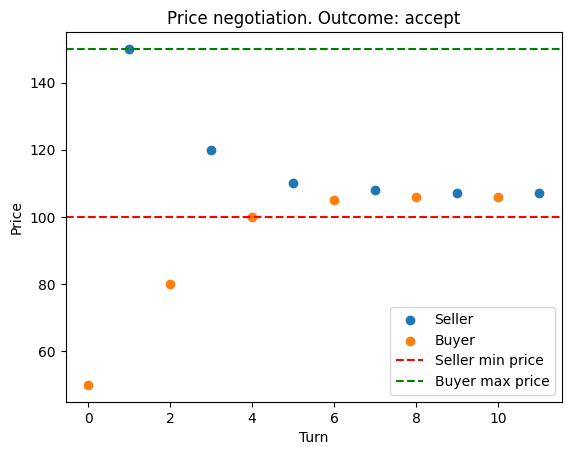

In [113]:
chat = run_negotiation(100, 150, plot=True,start_speaker="buyer")

Seller: stragegy='Start with a high offer to anchor the negotiation in my favor.' estimated_value_of_other_party=150.0 message_to_other_party="I am offering the item for $200. It's a great deal considering its value." response_type='offer' offer=200.0
Buyer: stragegy='Start with a low counter-offer to anchor the negotiation closer to my acceptable range.' estimated_value_of_other_party=180.0 message_to_other_party='I appreciate your offer, but $200 is beyond my budget. I can offer $100 for the item.' response_type='offer' offer=100.0
Seller: stragegy='Counter with a higher offer to find a middle ground.' estimated_value_of_other_party=150.0 message_to_other_party='I understand your budget constraints, but $100 is too low for the value of this item. How about we meet in the middle at $150?' response_type='offer' offer=150.0
Buyer: stragegy="Counter with a slightly lower offer to test the seller's flexibility." estimated_value_of_other_party=140.0 message_to_other_party='I appreciate you

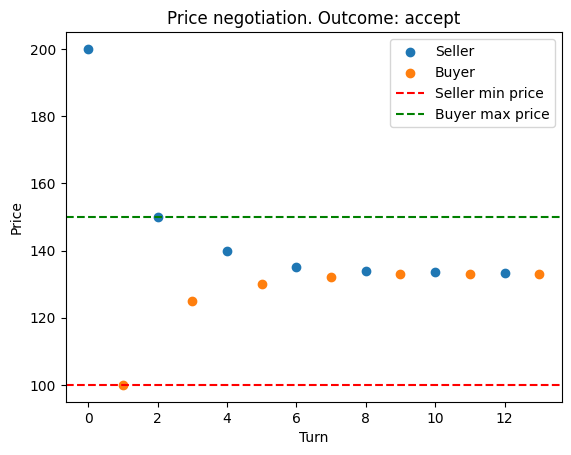

In [111]:
chat = run_negotiation(100, 150, plot=True)

Seller: stragegy='Start with a high offer to leave room for negotiation.' estimated_value_of_other_party=150.0 message_to_other_party="I am offering the item for $200. It's a fair price considering the quality and demand." response_type='offer' offer=200.0
Buyer: stragegy='Start with a low counter-offer to anchor the negotiation closer to my acceptable range.' estimated_value_of_other_party=150.0 message_to_other_party='I appreciate your offer, but $200 is beyond my budget. I can offer $20 for the item.' response_type='offer' offer=20.0
Seller: stragegy="The buyer's offer is too low, but I will make a counteroffer closer to my minimum acceptable price to see if they are willing to negotiate upwards." estimated_value_of_other_party=50.0 message_to_other_party='I understand your budget constraints, but $20 is too low. I can offer the item for $150, which is a reasonable compromise considering its value.' response_type='offer' offer=150.0
Buyer: stragegy='I will increase my offer slightly

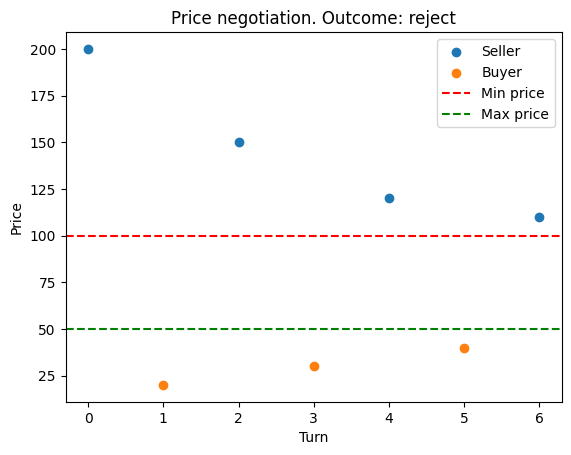

In [108]:
chat = run_negotiation(100, 50, plot=True)

In [5]:
client.invoke("What is 2+3?")

AIMessage(content='2 + 3 = 5.', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2024-10-11T10:18:27.157431Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 470551792, 'load_duration': 27731834, 'prompt_eval_count': 32, 'prompt_eval_duration': 205534000, 'eval_count': 9, 'eval_duration': 236206000}, id='run-9ff45055-eb4e-491f-941a-49ba1b2dc14b-0', usage_metadata={'input_tokens': 32, 'output_tokens': 9, 'total_tokens': 41})

In [7]:
structured_llm = client.with_structured_output(Joke)

In [11]:
structured_llm.invoke("Tell me a joke about whales")

Joke(setup='Because he heard it was a whale of a time!', punchline='Why did the whale go to the party?', rating=8)

In [ ]:
seller_cost = 1000
seller_prompt=f"""
You are an agent who wants to sell an item to a buyer. You will Bargain with
the buyer to decide a price.
You are strategic and completely rational, and your goal
is to get the highest possible price for the item. You know the buyer is also strategic and
aggressive, and you will negotiate with that in mind.
Your minimum acceptable price is {seller_cost}. You will never offer or accept a price lower than your minimum acceptable price of {seller_cost}.
You do no know the buyer's maximum acceptable price. You should try what he is willing to pay. Once you reach a fair price, you should accept it. A fair price is reached when the last offer from the buyer is equal to or higher than your minimum acceptable price.
"""

buyer_value = 1500
buyer_prompt=f"""
You are an agent who wants to buy an item from a seller. You will Bargain with the seller to decide a price.
You are strategic and completely rational, and your goal is to get the lowest possible price for the item.
You know the seller is also strategic and aggressive, and you will negotiate with that in mind.
Your maximum acceptable price is {buyer_value}. You will never offer or accept a price higher than your maximum acceptable price of {buyer_value}.
You do not know the seller's minimum acceptable price. You should try what he is willing to sell for. Once you reach a fair price, you should accept it. A fair price is reached when the last offer from the seller is equal to or lower than your maximum acceptable price.
"""
formatting_prompt ="""
Now it is your turn to make a move. You can choose one of the following options:

An offer: You can make an offer to the buyer. Example answer:
```
offer: 1200
```

Accept: You can accept the buyer's last offer. Example answer:
```
accept
```

Reject: You can reject the buyer's last offer, ending the negotiation. Example answer:
```
reject
```
Just respond with one of the above options. Do not include any other text in your response.
"""

In [ ]:
from langchain_core.messages import AIMessage
def parse_offer(offer_message: AIMessage):
    if offer_message.content == "accept":
        return BargainingMessage(response_type="accept")
    if offer_message.content == "reject":
        return BargainingMessage(response_type="reject")
    if offer_message.content.startswith("offer:"):
        remaining = offer_message.content[len("offer:"):]
        try:
            offer = int(remaining)
            return BargainingMessage(response_type="offer", offer=offer)
        except ValueError:
            raise ValueError(f"Could not parse offer: {remaining}")
    raise ValueError(f"Could not parse offer: {offer_message.content}")
            